## 目次
* **0. モジュールインポート**
* **1. ロード＆データチェック**
    * 1.1 データロード
    * 1.2 外れ値除外
    * 1.3 訓練データと適用データの結合
    * 1.4　欠損値チェック
    * 1.5 訓練データの概観チェック
* **2. 特徴量分析**
    * 2.1 量的データ
    * 2.2 質的データ
* **3. 特徴量エンジニアリング**
    * 3.1 質的データ->量的データの置換
    * 3.2 新しい特徴量の生成
    * 3.3 特徴量選択
    * 3.4 不要カラムの削除
    * 3.5 データセットの整備

## 0. モジュールインポート

In [4]:
# データ加工・処理モジュール
import numpy as np
import pandas as pd
import pandas_profiling as pdp
from datetime import datetime

# 可視化モジュール
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

#　前処理用モジュール
from collections import Counter
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import RFE
import datetime
import locale

# 機械学習モジュール
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb

# モデル評価モジュール
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report, average_precision_score

# 不均衡データ処理モジュール
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek

# マジックコマンド
%matplotlib inline

# 描画設定
sns.set(style='white', context='notebook', palette='deep')

# Jupyter設定
# 最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 100)
# 最大表示行数の指定
pd.set_option('display.max_rows', 100)

## 1. ロード＆データチェック

### 1.1 データロード

In [5]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
IDtest = test['id']

### 1.2 外れ値除外

In [ ]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["balance","duration","campaign","pdays", "previous"])

In [ ]:
train.loc[Outliers_to_drop]

In [ ]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 1.3 訓練データと適用データの結合

In [6]:
#　後で分割するときのためのフラグをセット
train = train.assign(flag = 'train')
test = test.assign(flag = 'test')

# 特徴量に対する処理を同一にするため、訓練データと適用データセットを結合
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [7]:
dataset

,age,balance,campaign,contact,day,default,duration,education,flag,housing,id,job,loan,marital,month,pdays,poutcome,previous,y
0,39,1756,1,cellular,3,no,939,secondary,train,yes,1,blue-collar,no,married,apr,-1,unknown,0,1.0
1,51,1443,10,cellular,18,no,172,primary,train,no,2,entrepreneur,no,married,feb,-1,unknown,0,1.0
2,36,436,1,cellular,13,no,567,tertiary,train,no,3,management,no,single,apr,595,failure,2,1.0
3,63,474,1,cellular,25,no,423,secondary,train,no,4,retired,no,married,jan,-1,unknown,0,1.0
4,31,354,1,cellular,30,no,502,tertiary,train,no,5,management,no,single,apr,9,success,2,1.0
5,29,260,14,unknown,2,no,707,secondary,train,yes,6,blue-collar,no,single,jun,-1,unknown,0,1.0
6,37,52,1,cellular,6,no,908,secondary,train,yes,7,services,no,married,sep,185,success,9,1.0
7,32,230,1,cellular,18,no,442,secondary,train,yes,8,technician,no,single,may,266,failure,8,1.0
8,31,0,2,cellular,7,no,895,secondary,train,yes,9,admin.,no,single,may,295,failure,2,1.0
9,32,1815,1,telephone,10,no,235,tertiary,train,no,10,self-employed,no,single,aug,102,failure,2,1.0


### 1.4 欠損値チェック

In [8]:
# 欠損値チェック
dataset.isnull().sum()

age              0
balance          0
campaign         0
contact          0
day              0
default          0
duration         0
education        0
flag             0
housing          0
id               0
job              0
loan             0
marital          0
month            0
pdays            0
poutcome         0
previous         0
y            18083
dtype: int64

### 1.5 訓練データの概要チェック

In [9]:
# データ型確認
train.dtypes

id            int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
flag         object
dtype: object

In [10]:
# 要約統計量
train.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000
mean,13564.500000,40.951010,1355.800870,15.806215,260.711295,2.751769,40.528052,0.579733,0.117001
std,7831.323388,10.608542,3003.305272,8.337904,260.091727,3.126594,100.382462,2.503653,0.321427
min,1.000000,18.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6782.750000,33.000000,72.000000,8.000000,104.000000,1.000000,-1.000000,0.000000,0.000000
50%,13564.500000,39.000000,449.000000,16.000000,182.000000,2.000000,-1.000000,0.000000,0.000000
75%,20346.250000,48.000000,1428.000000,21.000000,323.000000,3.000000,-1.000000,0.000000,0.000000
max,27128.000000,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


## 2. 特徴量分析

### **2.1 量的データ**

In [ ]:
pdp.ProfileReport(dataset)

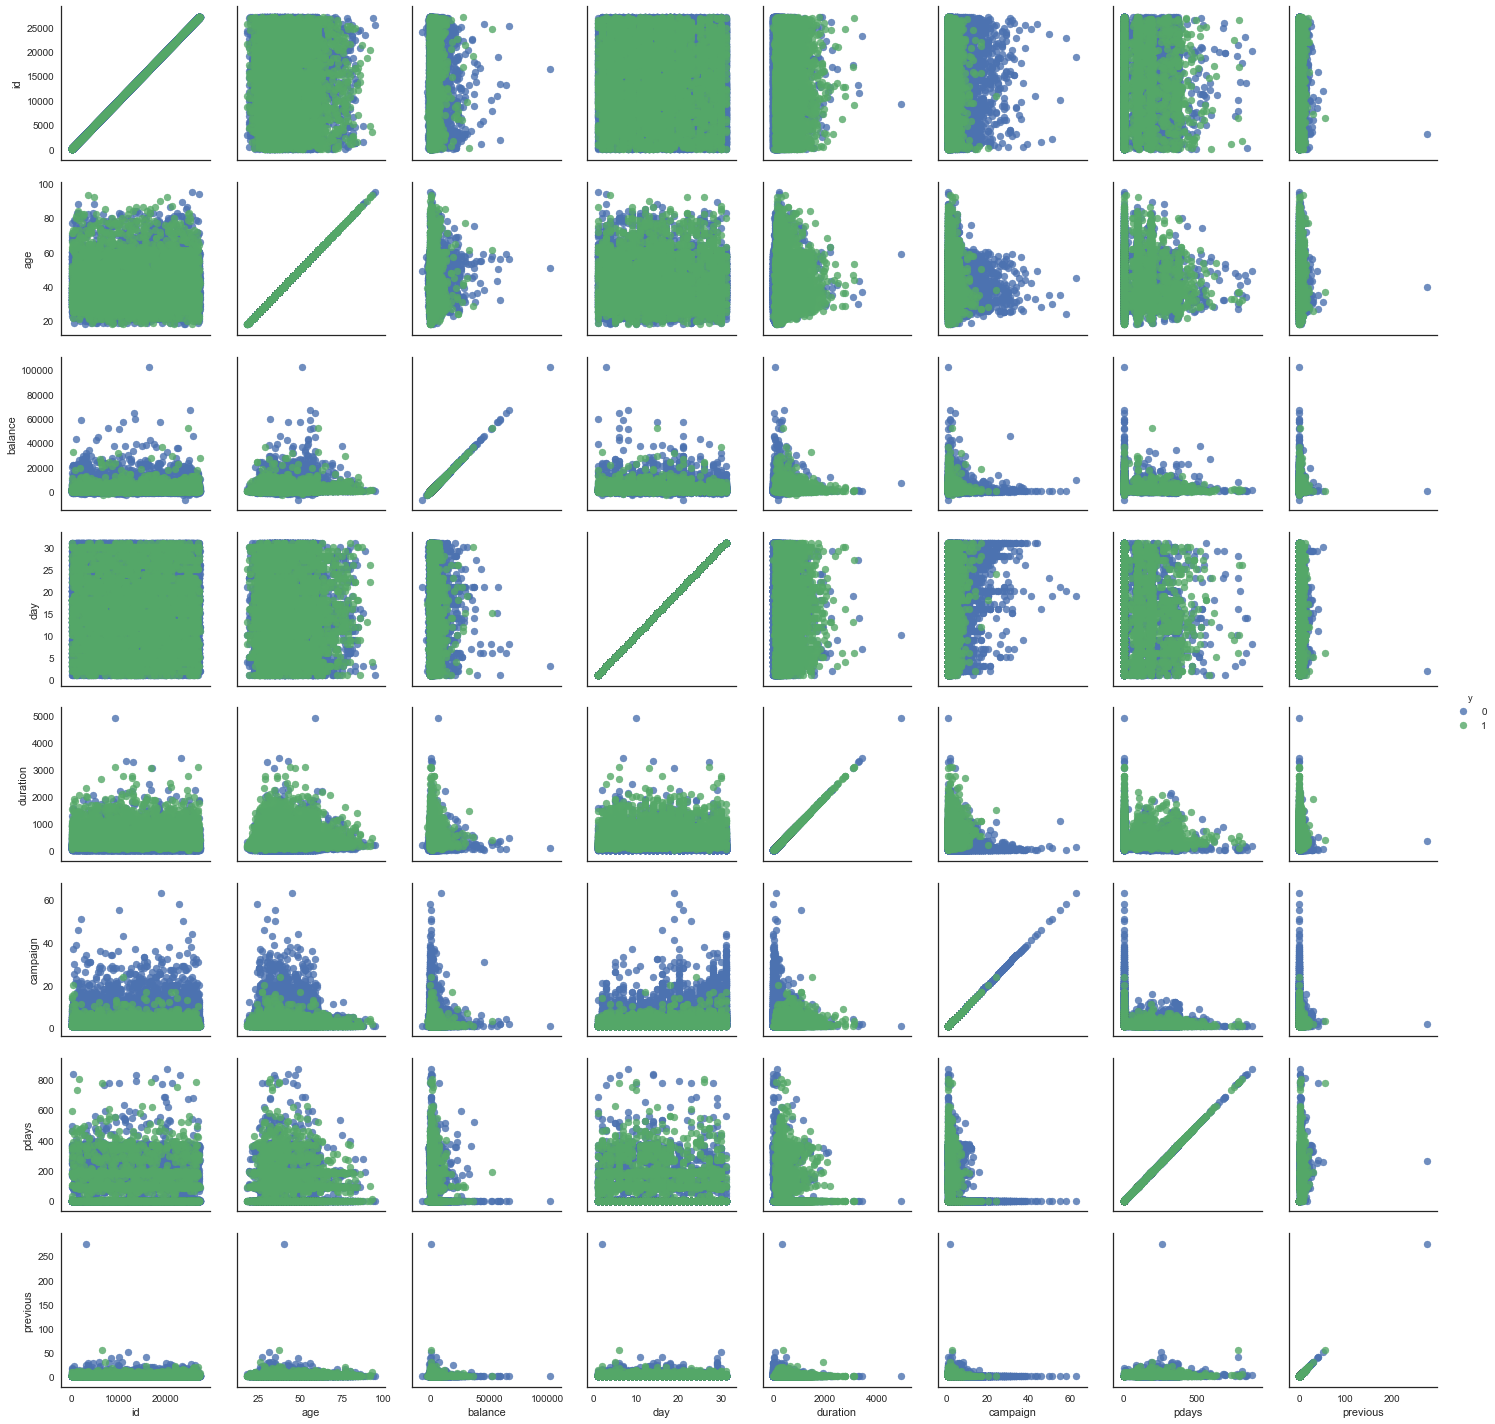

In [11]:
g = sns.PairGrid(train, vars=["id","age","balance","day","duration","campaign","pdays","previous"], hue='y').map(plt.scatter, alpha=0.8).add_legend()

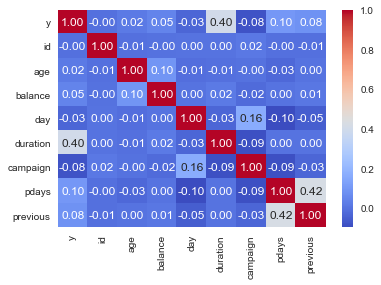

In [12]:
# 量的データと申込の相関行列
g = sns.heatmap(train[["y","id","age","balance","day","duration","campaign","pdays","previous"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

**id**

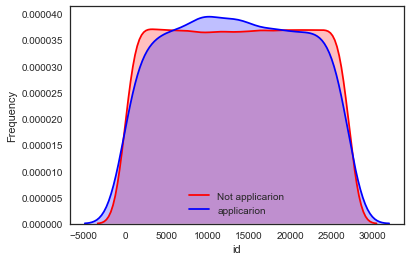

In [10]:
# 申込有無毎の分布
g = sns.kdeplot(train["id"][(train["y"] == 0) & (train["id"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["id"][(train["y"] == 1) & (train["id"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("id")
g.set_ylabel("Frequency")
g = g.legend(["Not applicarion","applicarion"])

In [ ]:
# 訓練データで状況確認
# ビニング（100分割）
bins = np.linspace(train['id'].min(), train['id'].max(), 100)
train['id_bin'] = np.digitize(train['id'], bins=bins)

In [ ]:
# 申込確率の可視化
g = sns.factorplot(x="id_bin", y="y", data=train, kind="bar", size=20, palette="muted")
g.despine(left=True)
g = g.set_ylabels("application probability")

In [ ]:
# データセットへビニングを適用
bins = np.linspace(dataset['id'].min(), dataset['id'].max(), 100)
dataset['id_bin'] = np.digitize(dataset['id'], bins=bins)

**age**

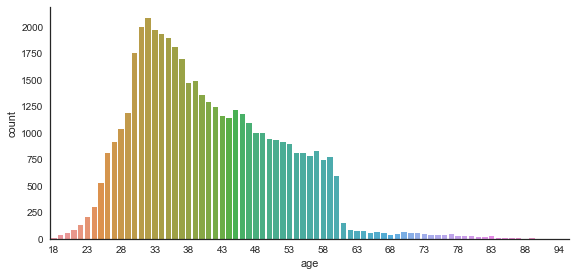

In [11]:
# カウントグラフ
g = sns.factorplot("age", data=dataset, aspect=2,kind="count")
g.set_xticklabels(step=5)

/Users/cw_suzuki/anaconda/envs/jupyter-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


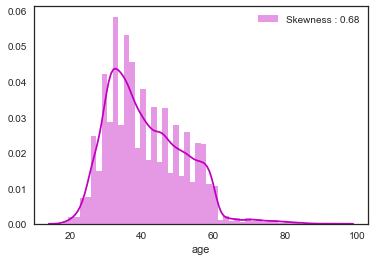

In [12]:
# データセットの分布を確認
g = sns.distplot(dataset["age"], color="m", label="Skewness : %.2f"%(dataset["age"].skew()))
g = g.legend(loc="best")

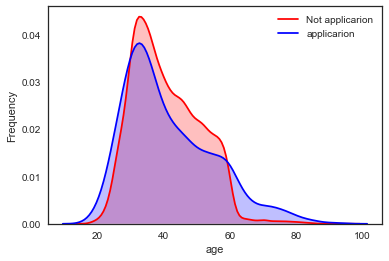

In [13]:
# 申込有無毎の分布
g = sns.kdeplot(train["age"][(train["y"] == 0) & (train["age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["age"][(train["y"] == 1) & (train["age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("age")
g.set_ylabel("Frequency")
g = g.legend(["Not applicarion","applicarion"])

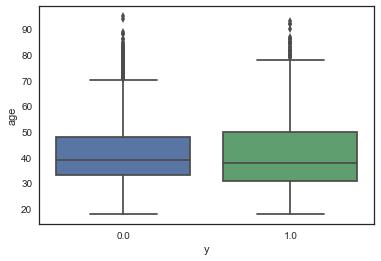

In [14]:
# 箱ひげ図
g = sns.boxplot(x="y", y="age", data=dataset.sort_values(by='y') )

**balance**

/Users/cw_suzuki/anaconda/envs/jupyter-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


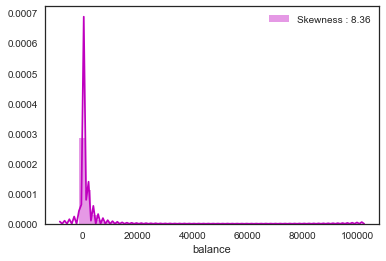

In [15]:
# データセットの分布を確認
g = sns.distplot(dataset["balance"], color="m", label="Skewness : %.2f"%(dataset["balance"].skew()))
g = g.legend(loc="best")

In [16]:
# 負の数を整数にする
dataset["balance"] = dataset["balance"] + 10000

# 対数化
dataset["balance_log"] = dataset["balance"].map(lambda i: np.log(i) if i > 0 else 0)

/Users/cw_suzuki/anaconda/envs/jupyter-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


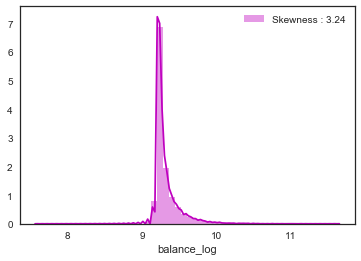

In [17]:
# データセットの分布を確認
g = sns.distplot(dataset["balance_log"], color="m", label="Skewness : %.2f"%(dataset["balance_log"].skew()))
g = g.legend(loc="best")

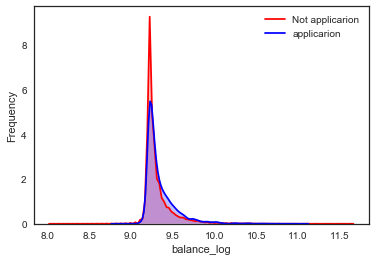

In [18]:
# 申込有無毎の分布
g = sns.kdeplot(dataset["balance_log"][(train["y"] == 0) & (dataset["balance_log"].notnull())], color="Red", shade = True)
g = sns.kdeplot(dataset["balance_log"][(train["y"] == 1) & (dataset["balance_log"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("balance_log")
g.set_ylabel("Frequency")
g = g.legend(["Not applicarion","applicarion"])

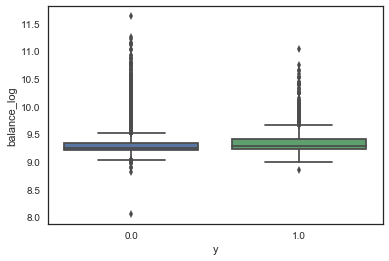

In [19]:
# 箱ひげ図
g = sns.boxplot(x="y", y="balance_log", data=dataset.sort_values(by='y') )

**day**

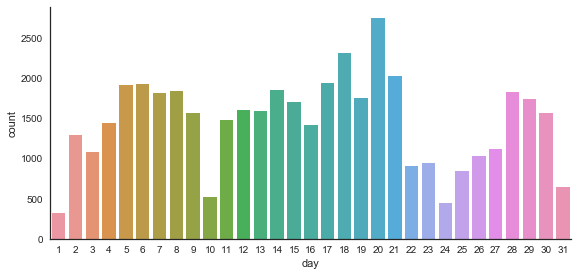

In [20]:
# カウントグラフ
g = sns.factorplot("day", data=dataset, aspect=2,kind="count")
g.set_xticklabels(step=1)

/Users/cw_suzuki/anaconda/envs/jupyter-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


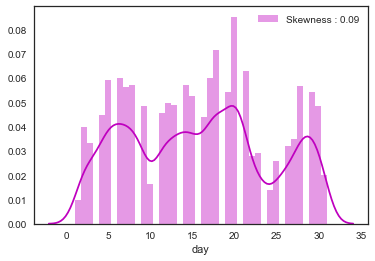

In [21]:
# データセットの分布を確認
g = sns.distplot(dataset["day"], color="m", label="Skewness : %.2f"%(dataset["day"].skew()))
g = g.legend(loc="best")

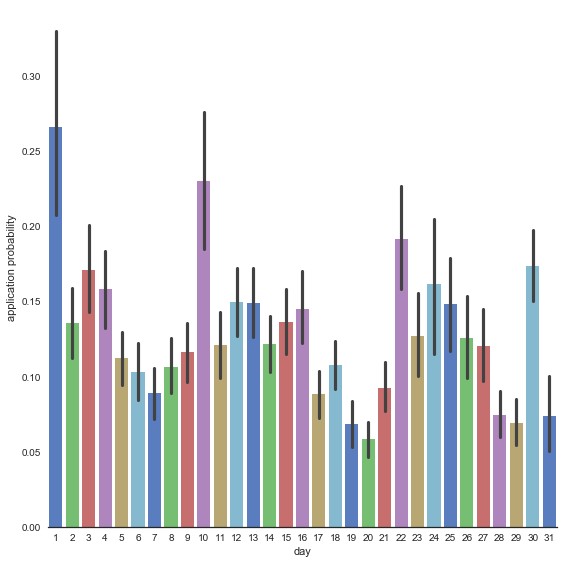

In [22]:
# 申込確率の可視化
g = sns.factorplot(x="day", y="y", data=train, kind="bar", size=8, palette="muted")
g.despine(left=True)
g = g.set_ylabels("application probability")

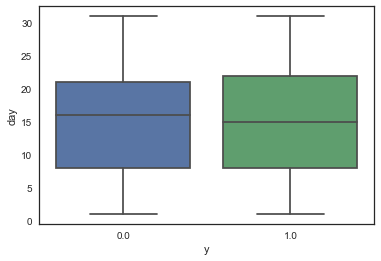

In [23]:
# 箱ひげ図
g = sns.boxplot(x="y", y="day", data=dataset.sort_values(by='y') )

**duration**

/Users/cw_suzuki/anaconda/envs/jupyter-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


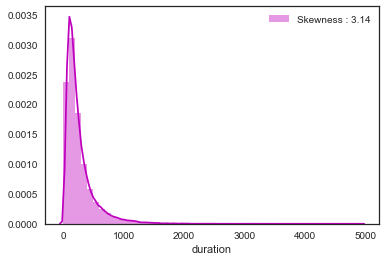

In [24]:
# データセットの分布を確認
g = sns.distplot(dataset["duration"], color="m", label="Skewness : %.2f"%(dataset["duration"].skew()))
g = g.legend(loc="best")

In [25]:
# 対数化
dataset["duration_log"] = dataset["duration"].map(lambda i: np.log(i) if i > 0 else 0)

/Users/cw_suzuki/anaconda/envs/jupyter-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


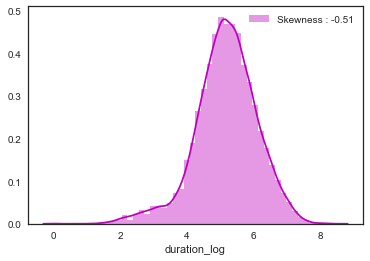

In [26]:
# データセットの分布を確認
g = sns.distplot(dataset["duration_log"], color="m", label="Skewness : %.2f"%(dataset["duration_log"].skew()))
g = g.legend(loc="best")

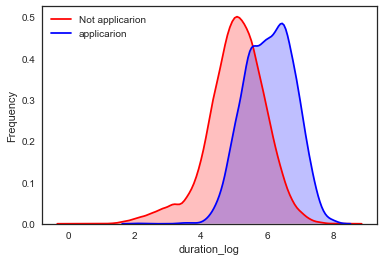

In [27]:
# 申込有無毎の分布
g = sns.kdeplot(dataset["duration_log"][(train["y"] == 0) & (dataset["duration_log"].notnull())], color="Red", shade = True)
g = sns.kdeplot(dataset["duration_log"][(train["y"] == 1) & (dataset["duration_log"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("duration_log")
g.set_ylabel("Frequency")
g = g.legend(["Not applicarion","applicarion"])

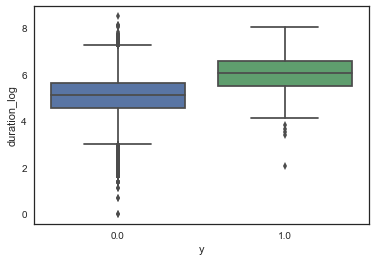

In [28]:
# 箱ひげ図
g = sns.boxplot(x="y", y="duration_log", data=dataset.sort_values(by='y') )

**campaign**

/Users/cw_suzuki/anaconda/envs/jupyter-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


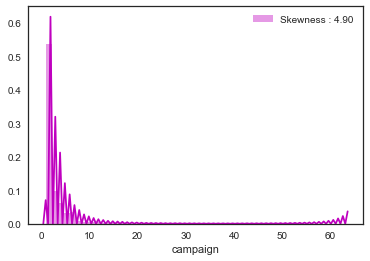

In [29]:
# データセットの分布を確認
g = sns.distplot(dataset["campaign"], color="m", label="Skewness : %.2f"%(dataset["campaign"].skew()))
g = g.legend(loc="best")

In [30]:
# 対数化
dataset["campaign_log"] = dataset["campaign"].map(lambda i: np.log(i) if i > 0 else 0)

/Users/cw_suzuki/anaconda/envs/jupyter-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


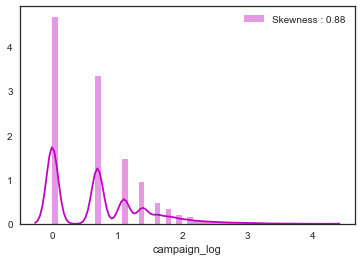

In [31]:
# データセットの分布を確認
g = sns.distplot(dataset["campaign_log"], color="m", label="Skewness : %.2f"%(dataset["campaign_log"].skew()))
g = g.legend(loc="best")

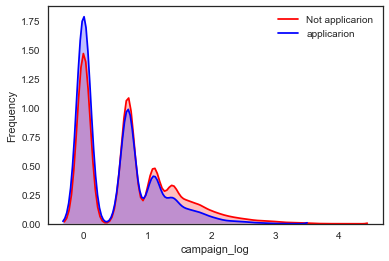

In [32]:
# 申込有無毎の分布
g = sns.kdeplot(dataset["campaign_log"][(train["y"] == 0) & (dataset["campaign_log"].notnull())], color="Red", shade = True)
g = sns.kdeplot(dataset["campaign_log"][(train["y"] == 1) & (dataset["campaign_log"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("campaign_log")
g.set_ylabel("Frequency")
g = g.legend(["Not applicarion","applicarion"])

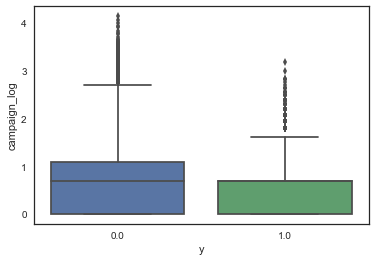

In [33]:
# 箱ひげ図
g = sns.boxplot(x="y", y="campaign_log", data=dataset.sort_values(by='y') )

**pdays**

/Users/cw_suzuki/anaconda/envs/jupyter-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


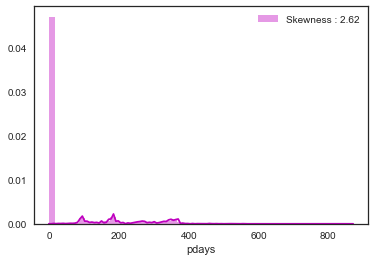

In [34]:
# データセットの分布を確認
g = sns.distplot(dataset["pdays"], color="m", label="Skewness : %.2f"%(dataset["pdays"].skew()))
g = g.legend(loc="best")

In [35]:
# 負のデータが存在
dataset["pdays"] = dataset["pdays"] + 1

# 対数化
dataset["pdays_log"] = dataset["pdays"].map(lambda i: np.log(i) if i > 0 else 0)

/Users/cw_suzuki/anaconda/envs/jupyter-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


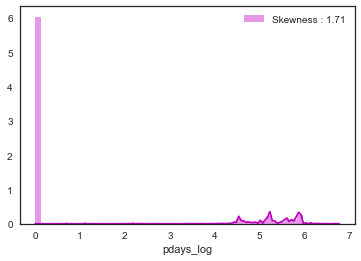

In [36]:
# データセットの分布を確認
g = sns.distplot(dataset["pdays_log"], color="m", label="Skewness : %.2f"%(dataset["pdays_log"].skew()))
g = g.legend(loc="best")

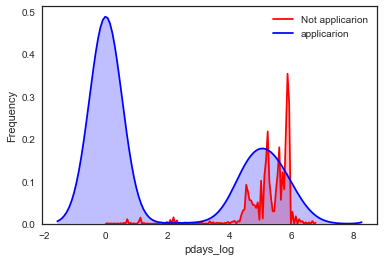

In [37]:
# 申込有無毎の分布
g = sns.kdeplot(dataset["pdays_log"][(train["y"] == 0) & (dataset["pdays_log"].notnull())], color="Red", shade = True)
g = sns.kdeplot(dataset["pdays_log"][(train["y"] == 1) & (dataset["pdays_log"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("pdays_log")
g.set_ylabel("Frequency")
g = g.legend(["Not applicarion","applicarion"])

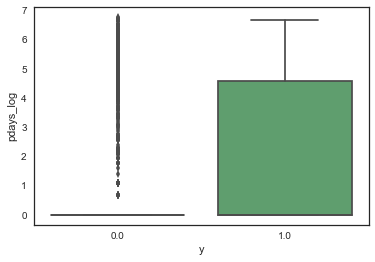

In [38]:
# 箱ひげ図
g = sns.boxplot(x="y", y="pdays_log", data=dataset.sort_values(by='y') )

**previous**

/Users/cw_suzuki/anaconda/envs/jupyter-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


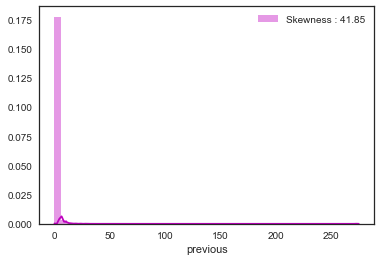

In [39]:
# データセットの分布を確認
g = sns.distplot(dataset["previous"], color="m", label="Skewness : %.2f"%(dataset["previous"].skew()))
g = g.legend(loc="best")

In [40]:
# 対数化
dataset["previous_log"] = dataset["previous"].map(lambda i: np.log(i) if i > 0 else 0)

/Users/cw_suzuki/anaconda/envs/jupyter-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


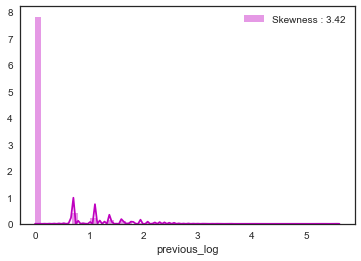

In [41]:
# データセットの分布を確認
g = sns.distplot(dataset["previous_log"], color="m", label="Skewness : %.2f"%(dataset["previous_log"].skew()))
g = g.legend(loc="best")

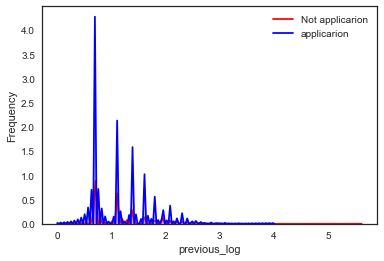

In [42]:
# 申込有無毎の分布
g = sns.kdeplot(dataset["previous_log"][(train["y"] == 0) & (dataset["previous_log"].notnull())], color="Red", shade = True)
g = sns.kdeplot(dataset["previous_log"][(train["y"] == 1) & (dataset["previous_log"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("previous_log")
g.set_ylabel("Frequency")
g = g.legend(["Not applicarion","applicarion"])

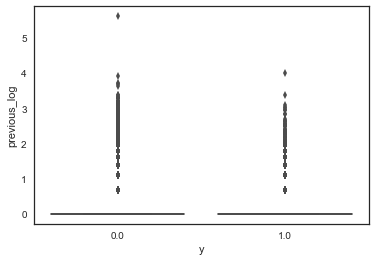

In [43]:
# 箱ひげ図
g = sns.boxplot(x="y", y="previous_log", data=dataset.sort_values(by='y') )

### **2.2 質的データ**

**job**

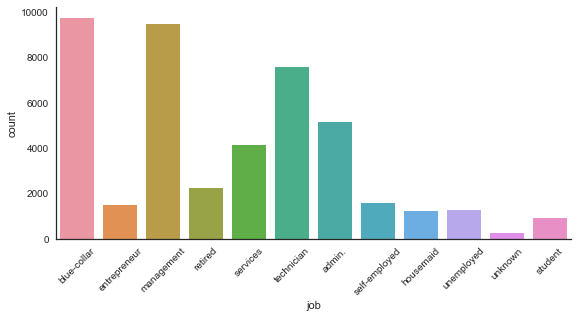

In [44]:
# カウントグラフ
g = sns.factorplot("job", data=dataset, aspect=2,kind="count")
plt.xticks(rotation=45)
g.set_xticklabels(step=1)

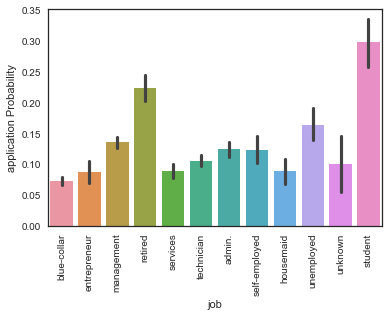

In [45]:
# 申込確率の可視化
g = sns.barplot(x="job", y="y", data=train)
g = g.set_ylabel("application Probability")
plt.xticks(rotation=90)
plt.show()

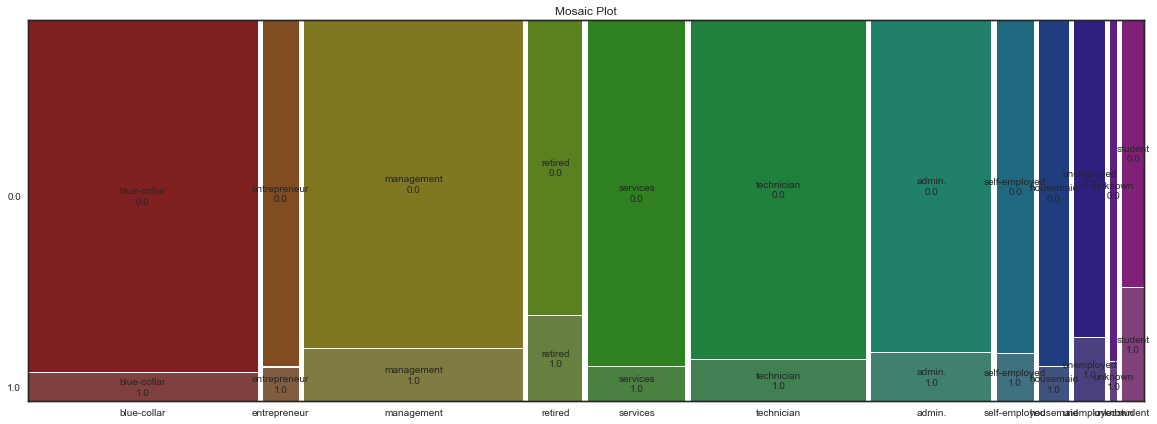

In [46]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['job', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

**marital**

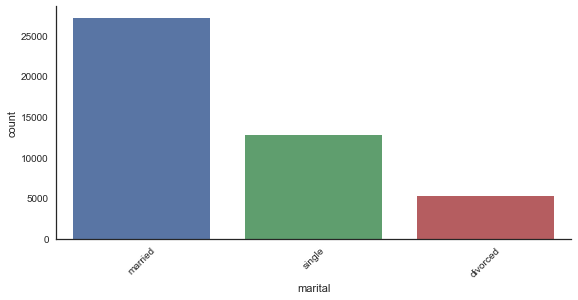

In [47]:
# カウントグラフ
g = sns.factorplot("marital", data=dataset, aspect=2,kind="count")
plt.xticks(rotation=45)
g.set_xticklabels(step=1)

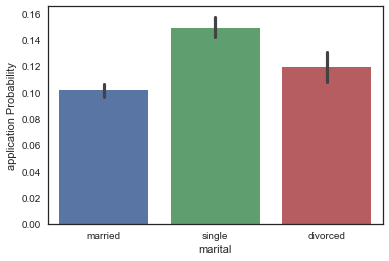

In [48]:
# 申込確率の可視化
g = sns.barplot(x="marital", y="y", data=dataset)
g = g.set_ylabel("application Probability")

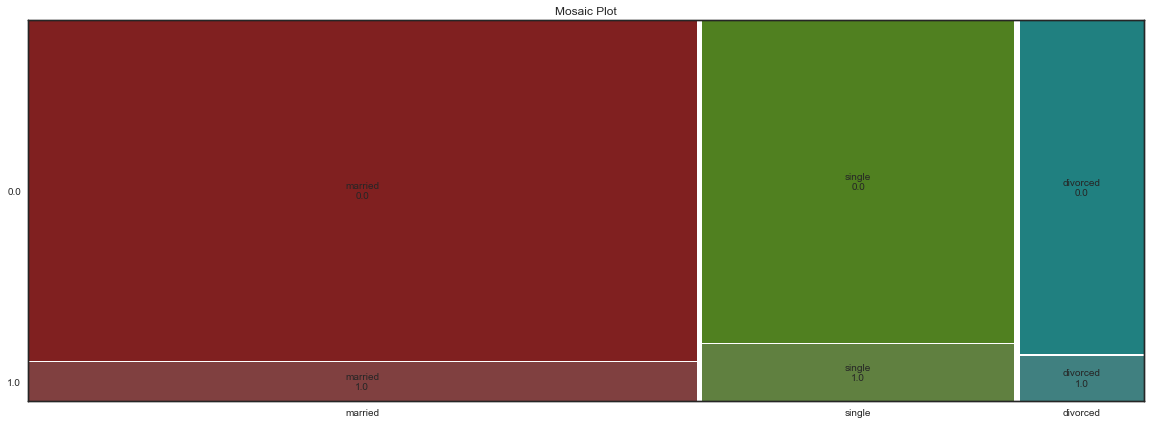

In [49]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['marital', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

**education**

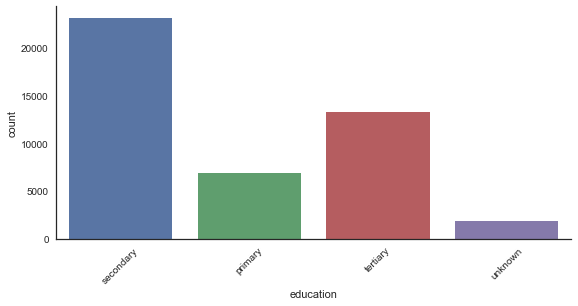

In [50]:
# カウントグラフ
g = sns.factorplot("education", data=dataset, aspect=2,kind="count")
plt.xticks(rotation=45)
g.set_xticklabels(step=1)

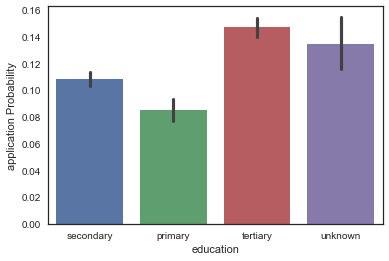

In [51]:
# 申込確率の可視化
g = sns.barplot(x="education", y="y", data=dataset)
g = g.set_ylabel("application Probability")

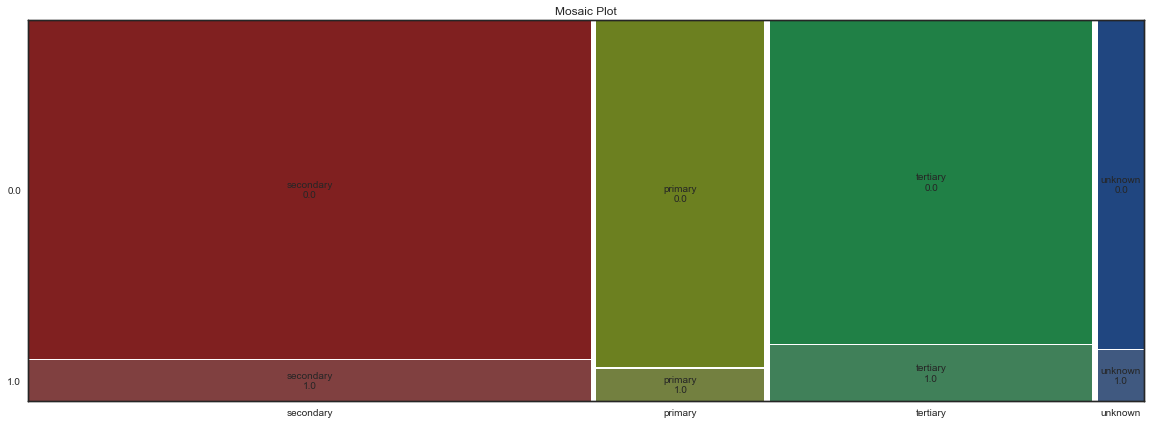

In [52]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['education', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

**default**

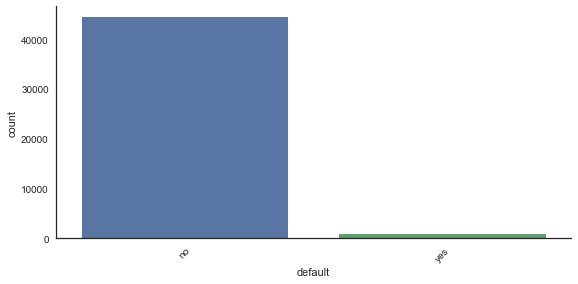

In [53]:
# カウントグラフ
g = sns.factorplot("default", data=dataset, aspect=2,kind="count")
plt.xticks(rotation=45)
g.set_xticklabels(step=1)

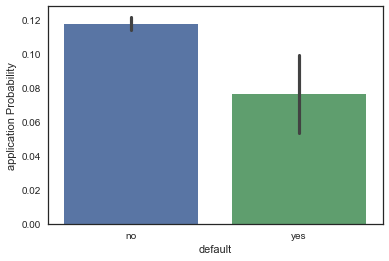

In [54]:
# 申込確率の可視化
g = sns.barplot(x="default", y="y", data=dataset)
g = g.set_ylabel("application Probability")

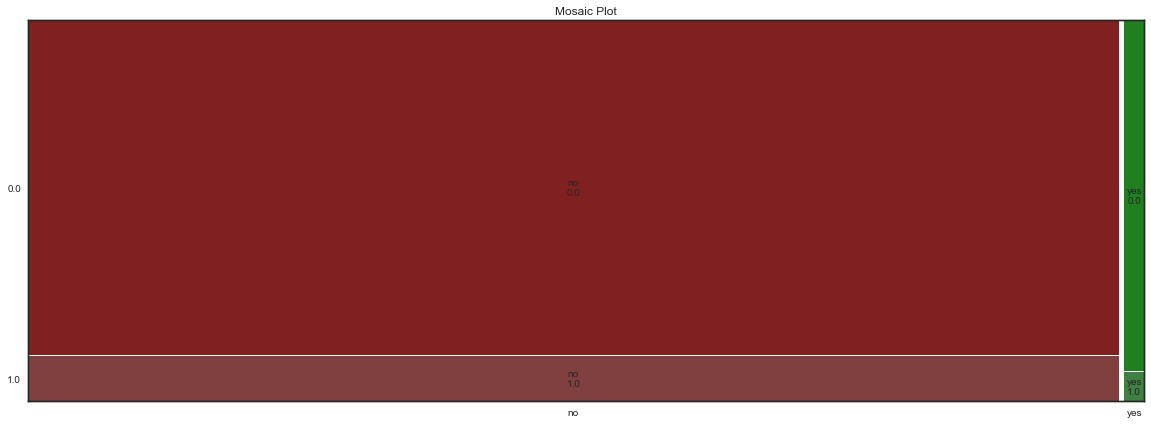

In [55]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['default', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

**housing**

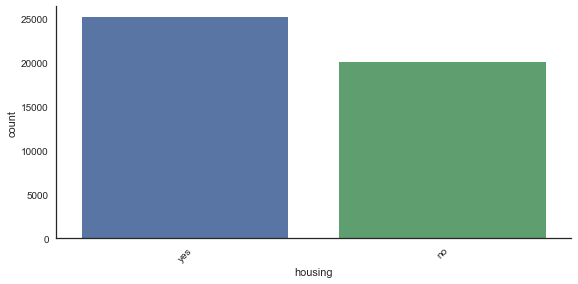

In [56]:
# カウントグラフ
g = sns.factorplot("housing", data=dataset, aspect=2,kind="count")
plt.xticks(rotation=45)
g.set_xticklabels(step=1)

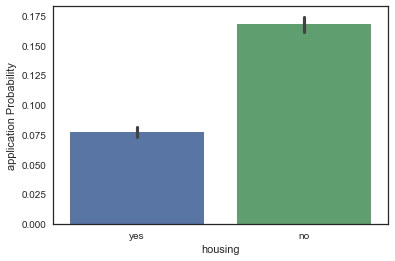

In [57]:
# 申込確率の可視化
g = sns.barplot(x="housing", y="y", data=dataset)
g = g.set_ylabel("application Probability")

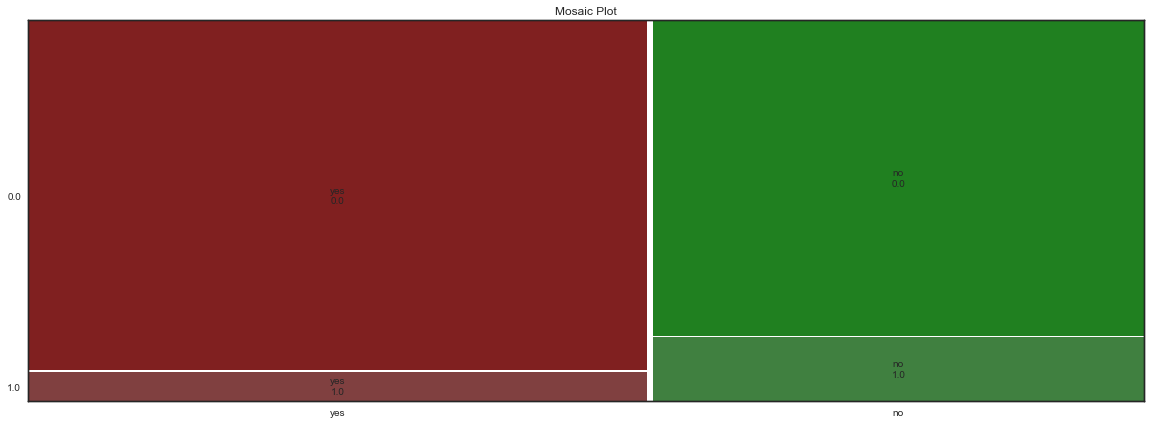

In [58]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['housing', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

**loan**

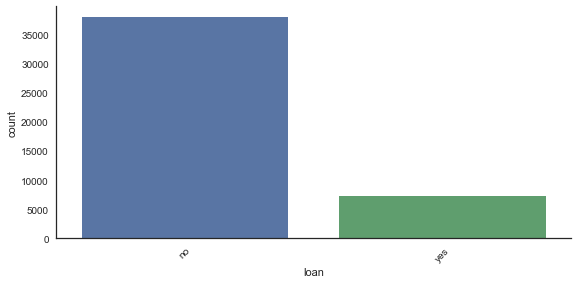

In [59]:
# カウントグラフ
g = sns.factorplot("loan", data=dataset, aspect=2,kind="count")
plt.xticks(rotation=45)
g.set_xticklabels(step=1)

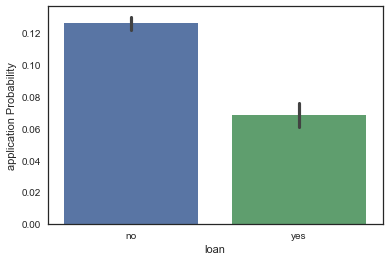

In [60]:
# 申込確率の可視化
g = sns.barplot(x="loan", y="y", data=dataset)
g = g.set_ylabel("application Probability")

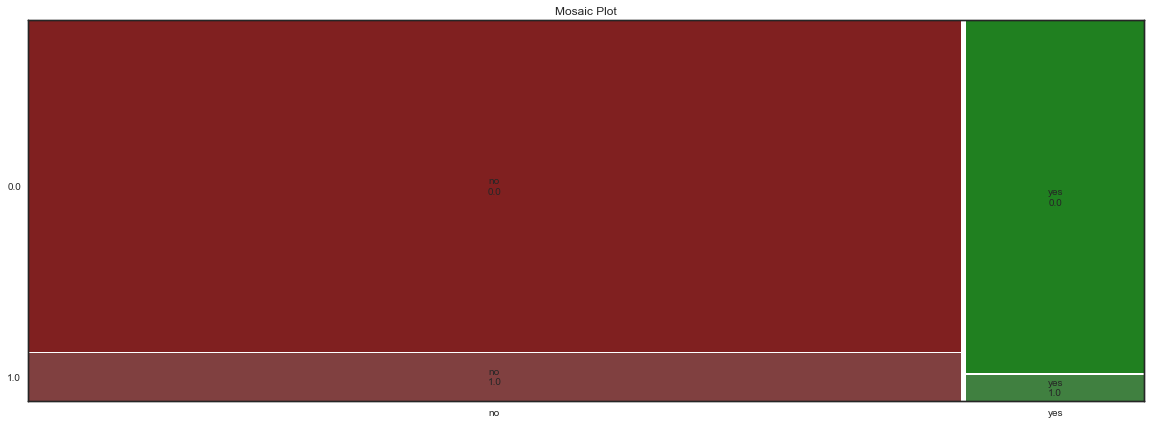

In [61]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['loan', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

**contact**

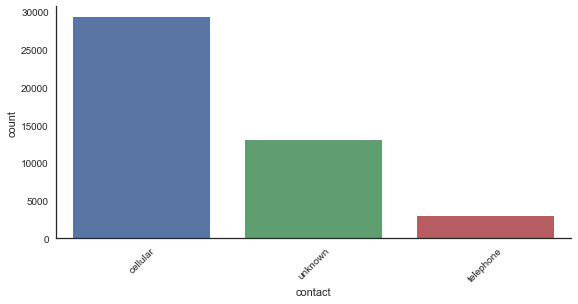

In [62]:
# カウントグラフ
g = sns.factorplot("contact", data=dataset, aspect=2,kind="count")
plt.xticks(rotation=45)
g.set_xticklabels(step=1)

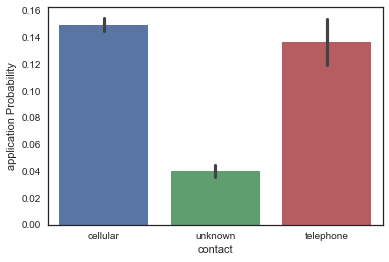

In [63]:
# 申込確率の可視化
g = sns.barplot(x="contact", y="y", data=dataset)
g = g.set_ylabel("application Probability")

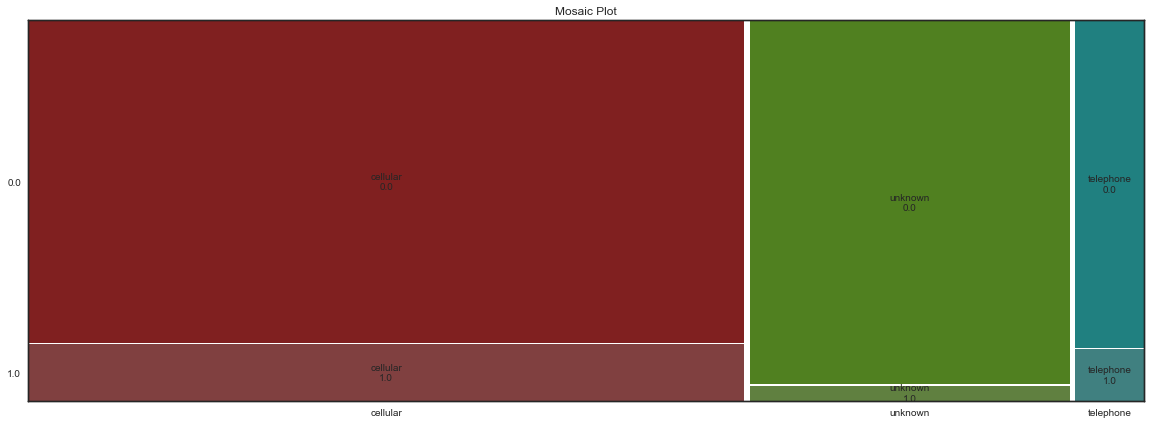

In [64]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['contact', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

**month**

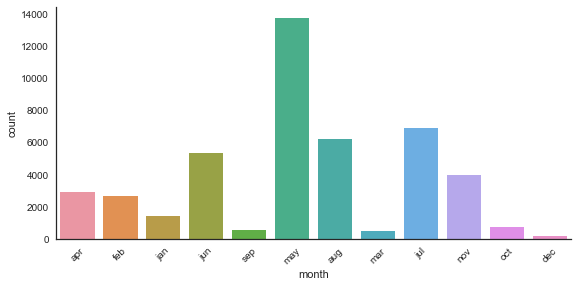

In [65]:
# カウントグラフ
g = sns.factorplot("month", data=dataset, aspect=2,kind="count")
plt.xticks(rotation=45)
g.set_xticklabels(step=1)

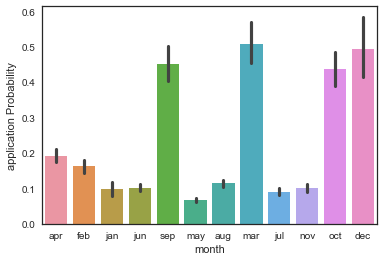

In [66]:
# 申込確率の可視化
g = sns.barplot(x="month", y="y", data=train)
g = g.set_ylabel("application Probability")

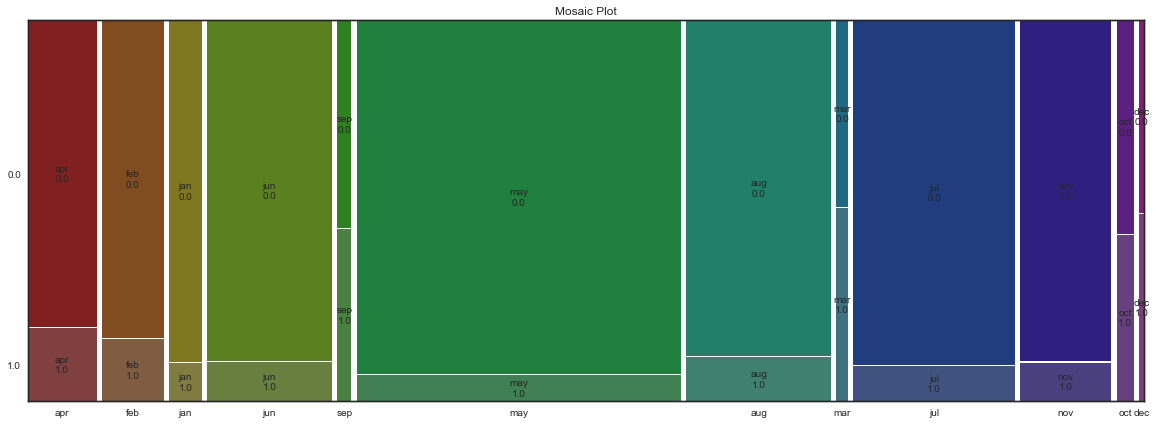

In [67]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['month', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

**poutcome**

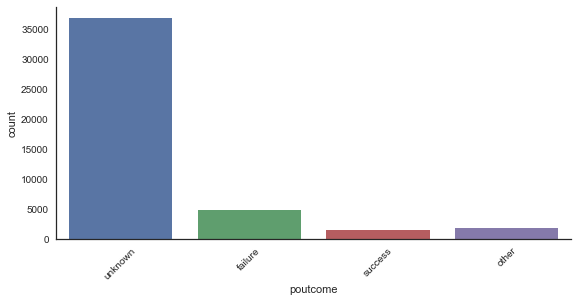

In [68]:
# カウントグラフ
g = sns.factorplot("poutcome", data=dataset, aspect=2,kind="count")
plt.xticks(rotation=45)
g.set_xticklabels(step=1)

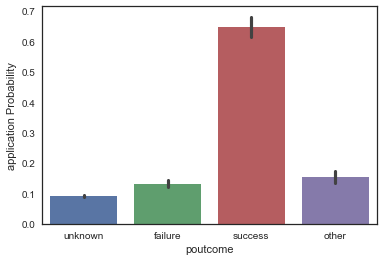

In [69]:
# 申込確率の可視化
g = sns.barplot(x="poutcome", y="y", data=dataset)
g = g.set_ylabel("application Probability")

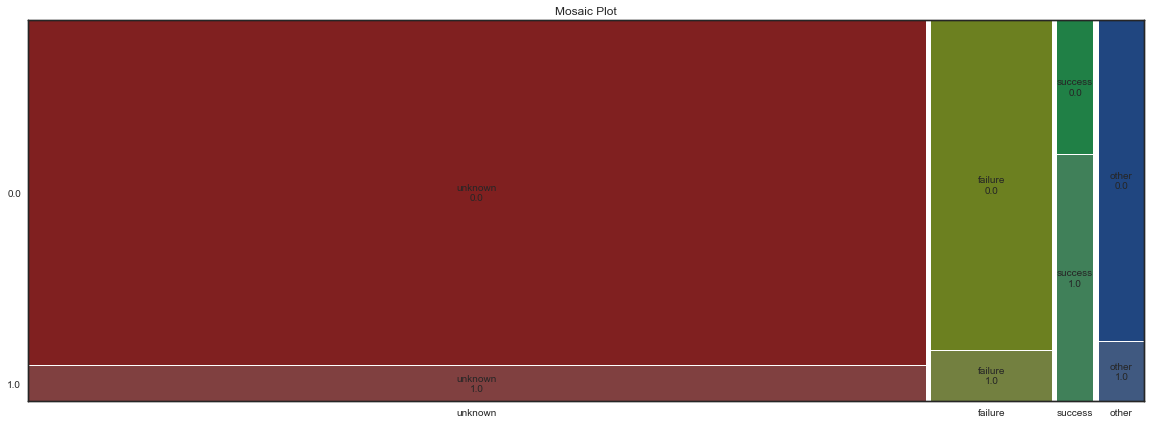

In [70]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['poutcome', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

## 3. 特徴量エンジニアリング

### 3.1 質的データ->量的データの置換

#### 3.1.1 2値変換

In [71]:
# LabelEncoder により2値の質的データ->量的データに置換
LE=LabelEncoder()

labels = ["default", "housing","loan"]
for label in labels:
    dataset[label]=LE.fit_transform(dataset[label])

#### 3.1.2 多値変換（ワンホットエンコーディングのみ）

In [72]:
# ワンホットエンコーディングにより多値の質的データ->量的データに置換
dummies = pd.get_dummies(dataset[["marital", "education", "job", "month", "poutcome", "contact"]], drop_first=False)

# 元のデータセットと結合
dataset = pd.merge(dataset, dummies, left_index=True, right_index=True)

#### 3.1.3 多値変換（ワンホットエンコーディング＋次元削減）

**job**

In [ ]:
# category型のマスターデータを生成
dataset['job_rep'] = pd.Categorical(dataset['job'])

# マスターデータに"other"を作成
dataset['job_rep'].cat.add_categories(['other'], inplace=True)

# 集約するデータを書き換え
dataset.loc[dataset['job_rep'].isin(['blue-collar', 'entrepreneur', 'services', 'technician', 'admin.', 'self-employed', 'housemaid', 'unknown']), 'job_rep'] = 'other'

# 不要なマスターデータおよびカラムを削除
dataset['job_rep'].cat.remove_unused_categories(inplace=True)

# ワンホットエンコーディングにより多値の質的データ->量的データに置換
dummies = pd.get_dummies(dataset[["job_rep"]], drop_first=False)

# 元のデータセットと結合
dataset = pd.merge(dataset, dummies, left_index=True, right_index=True)

In [ ]:
# カウントグラフ
g = sns.factorplot("job_rep", data=dataset, aspect=2,kind="count")
plt.xticks(rotation=45)
g.set_xticklabels(step=1)

In [ ]:
# 申込確率の可視化
g = sns.barplot(x="job_rep", y="y", data=dataset)
g = g.set_ylabel("application Probability")

In [ ]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['job_rep', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 不要なカラムを削除
dataset = dataset.drop("job_rep", axis=1)

**month**

In [ ]:
# category型のマスターデータを生成
dataset['month_rep'] = pd.Categorical(dataset['month'])

# マスターデータに"other"を作成
dataset['month_rep'].cat.add_categories(['more_large'], inplace=True)
dataset['month_rep'].cat.add_categories(['large'], inplace=True)
dataset['month_rep'].cat.add_categories(['small'], inplace=True)
dataset['month_rep'].cat.add_categories(['more_small'], inplace=True)

# 集約するデータを書き換え
dataset.loc[dataset['month_rep'].isin(['may']), 'month_rep'] = 'more_large'
dataset.loc[dataset['month_rep'].isin(['jun',  'aug', 'jul', 'nov']), 'month_rep'] = 'large'
dataset.loc[dataset['month_rep'].isin(['jan','apr', 'feb']), 'month_rep'] = 'small'
dataset.loc[dataset['month_rep'].isin(['sep', 'mar', 'oct', 'dec']), 'month_rep'] = 'more_small'

# 不要なマスターデータおよびカラムを削除
dataset['month_rep'].cat.remove_unused_categories(inplace=True)

# ワンホットエンコーディングにより多値の質的データ->量的データに置換
dummies = pd.get_dummies(dataset[["month_rep"]], drop_first=False)

# 元のデータセットと結合
dataset = pd.merge(dataset, dummies, left_index=True, right_index=True)

In [ ]:
# カウントグラフ
g = sns.factorplot("month_rep", data=dataset, aspect=2,kind="count")
plt.xticks(rotation=45)
g.set_xticklabels(step=1)

In [ ]:
# 申込確率の可視化
g = sns.barplot(x="month_rep", y="y", data=dataset)
g = g.set_ylabel("application Probability")

In [ ]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['month_rep', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 不要なカラムを削除
dataset = dataset.drop("month_rep", axis=1)

**poutcome**

In [ ]:
# category型のマスターデータを生成
dataset['poutcome_rep'] = pd.Categorical(dataset['poutcome'])

# マスターデータに"other"を作成
dataset['poutcome_rep'].cat.add_categories(['yes'], inplace=True)
dataset['poutcome_rep'].cat.add_categories(['no'], inplace=True)

# 集約するデータを書き換え
dataset.loc[dataset['poutcome_rep'].isin(['success']), 'poutcome_rep'] = 'yes'
dataset.loc[dataset['poutcome_rep'].isin(['unknown', 'failure', 'other']), 'poutcome_rep'] = 'no'

# 不要なマスターデータを削除
dataset['poutcome_rep'].cat.remove_unused_categories(inplace=True)

# LabelEncoder により2値の質的データ->量的データに置換
LE=LabelEncoder()
dataset['poutcome_rep']=LE.fit_transform(dataset['poutcome_rep'])

In [ ]:
# カウントグラフ
g = sns.factorplot("poutcome_rep", data=dataset, aspect=2,kind="count")
g.set_xticklabels(step=1)

In [ ]:
# 申込確率の可視化
g = sns.barplot(x="poutcome_rep", y="y", data=dataset)
g = g.set_ylabel("application Probability")

In [ ]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['poutcome_rep', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 不要なカラムを削除
dataset = dataset.drop("poutcome_rep", axis=1)

**contact**

In [ ]:
# category型のマスターデータを生成
dataset['contact_rep'] = pd.Categorical(dataset['contact'])

# マスターデータに"other"を作成
dataset['contact_rep'].cat.add_categories(['yes'], inplace=True)
dataset['contact_rep'].cat.add_categories(['no'], inplace=True)

# 集約するデータを書き換え
dataset.loc[dataset['contact_rep'].isin(['cellular', 'telephone']), 'contact_rep'] = 'yes'
dataset.loc[dataset['contact_rep'].isin(['unknown']), 'contact_rep'] = 'no'

# 不要なマスターデータを削除
dataset['contact_rep'].cat.remove_unused_categories(inplace=True)

# LabelEncoder により2値の質的データ->量的データに置換
LE=LabelEncoder()
dataset['contact_rep']=LE.fit_transform(dataset['contact_rep'])

In [ ]:
# カウントグラフ
g = sns.factorplot("contact_rep", data=dataset, aspect=2,kind="count")
g.set_xticklabels(step=1)

In [ ]:
# 申込確率の可視化
g = sns.barplot(x="contact_rep", y="y", data=dataset)
g = g.set_ylabel("application Probability")

In [ ]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['contact_rep', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 不要なカラムを削除
dataset = dataset.drop("contact_rep", axis=1)

### 3.2 新しい特徴量の生成

**date（最終接触月日）**

In [73]:
# 置換文字列の辞書型を作成
month = {'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'may': '05', 'jun': '06', 'jul': '07', 'aug': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'}

# 月を英文字列 -> 数字へ変換
dataset = dataset.replace(month)

# 日をゼロパディング
dataset['day_zfl'] = dataset['day'].astype(str).str.zfill(2)

# "年月日（文字列）"カラムを生成
dataset['date'] = '2000-' + dataset['month'].astype(str) + '-' + dataset['day_zfl'].astype(str) + ' ' + '00:00:00'

# 年月日を数値型へ置換
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['date'] = dataset['date'].astype(np.int64)
dataset['date'] = dataset['date'].astype(str).str.replace('00000000000','')
dataset['date'] = dataset['date'].astype('int64')

# 生成
df = pd.DataFrame(index=[], columns=['date'])
df['date'] = '2000-' + dataset['month'].astype(str) + '-' + dataset['day_zfl'].astype(str)
df['date'] = pd.to_datetime(df['date'] )
df.set_index('date', inplace=True)

# "不要カラムを削除
dataset = dataset.drop("day_zfl", axis=1)    

/Users/cw_suzuki/anaconda/envs/jupyter-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


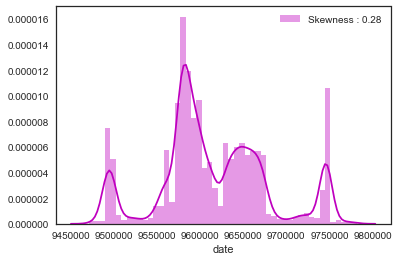

In [74]:
# データセットの分布を確認
g = sns.distplot(dataset["date"], color="m", label="Skewness : %.2f"%(dataset["date"].skew()))
g = g.legend(loc="best")

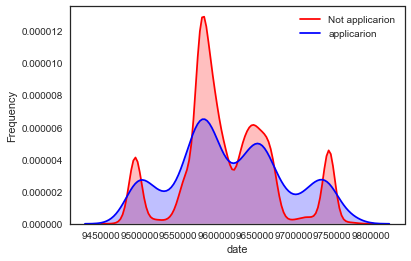

In [75]:
# 申込有無毎の分布
g = sns.kdeplot(dataset["date"][(train["y"] == 0) & (dataset["date"].notnull())], color="Red", shade = True)
g = sns.kdeplot(dataset["date"][(train["y"] == 1) & (dataset["date"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("date")
g.set_ylabel("Frequency")
g = g.legend(["Not applicarion","applicarion"])

**date_of_week（最終接触日の曜日）**

In [76]:
# date_of_week格納用のデータフレームを作成
date_of_week = pd.DataFrame(index=[], columns=['date_of_week'])

# 作成したデータフレームに曜日をセット
for column_name, item in dataset.iteritems():
    date_of_week['date_of_week'] = df.index.weekday

# datasetと結合
dataset =  pd.concat(objs=[dataset, date_of_week], axis=1)

In [77]:
# ワンホットエンコーディングにより多値の質的データ->量的データに置換
dataset["date_of_week"]=dataset["date_of_week"].astype(str)
dummies = pd.get_dummies(dataset[['date_of_week']], drop_first=False)

# 元のデータセットと結合
dataset = pd.merge(dataset, dummies, left_index=True, right_index=True)

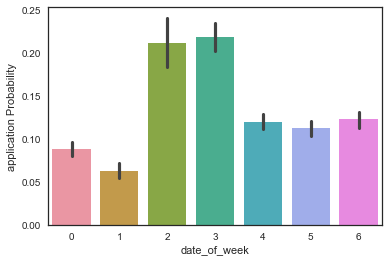

In [78]:
# 申込確率の可視化
g = sns.barplot(x="date_of_week", y="y", data=dataset)
g = g.set_ylabel("application Probability")

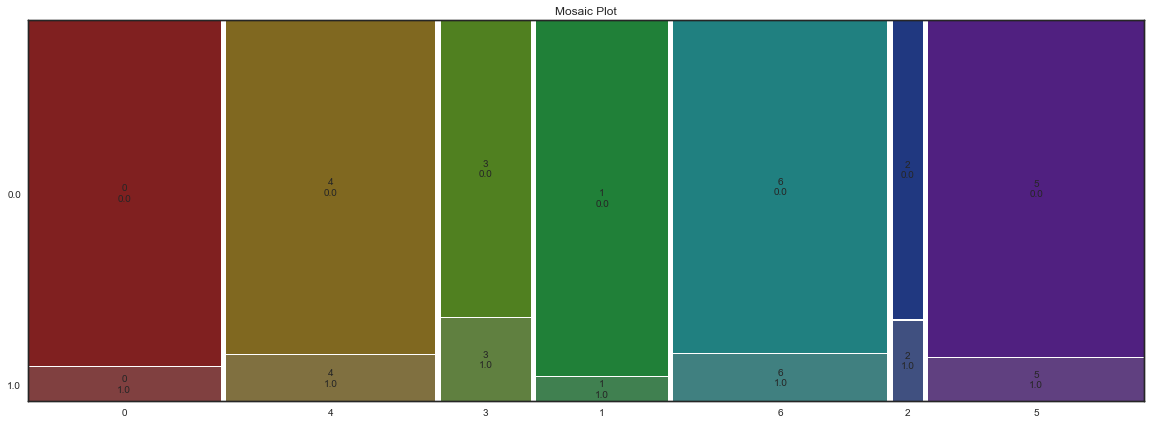

In [79]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['date_of_week', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# マスターデータにカテゴリを作成
dataset['date_of_week_rep'].cat.add_categories(['large'], inplace=True)
dataset['date_of_week_rep'].cat.add_categories(['middle'], inplace=True)
dataset['date_of_week_rep'].cat.add_categories(['small'], inplace=True)

# 集約するデータを書き換え
dataset.loc[dataset['date_of_week_rep'].isin([2,3]), 'date_of_week_rep'] = 'large'
dataset.loc[dataset['date_of_week_rep'].isin([4,5,6]), 'date_of_week_rep'] = 'middle'
dataset.loc[dataset['date_of_week_rep'].isin([0,1]), 'date_of_week_rep'] = 'small'

# 不要なマスターデータを削除
dataset['date_of_week_rep'].cat.remove_unused_categories(inplace=True)

# ワンホットエンコーディングにより多値の質的データ->量的データに置換
dummies = pd.get_dummies(dataset[["date_of_week_rep"]], drop_first=False)

# 元のデータセットと結合
dataset = pd.merge(dataset, dummies, left_index=True, right_index=True)

# 不要なカラムを削除
dataset = dataset.drop("date_of_week_rep", axis=1)

**solvency_score（支払能力スコア）**

In [80]:
# "default","housing","loan"の値を合計
dataset["solvency_score"] = dataset["default"] + dataset["housing"] + dataset["loan"]

In [81]:
# ワンホットエンコーディングにより多値の質的データ->量的データに置換
dataset["solvency_score"]=dataset["solvency_score"].astype(str)
dummies = pd.get_dummies(dataset[['solvency_score']], drop_first=False)

# 元のデータセットと結合
dataset = pd.merge(dataset, dummies, left_index=True, right_index=True)

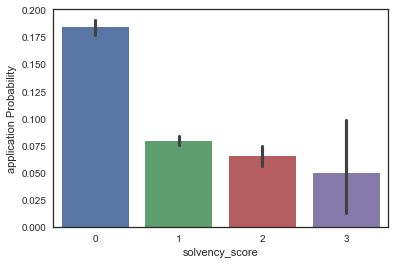

In [82]:
# 申込確率の可視化
g = sns.barplot(x="solvency_score", y="y", data=dataset)
g = g.set_ylabel("application Probability")

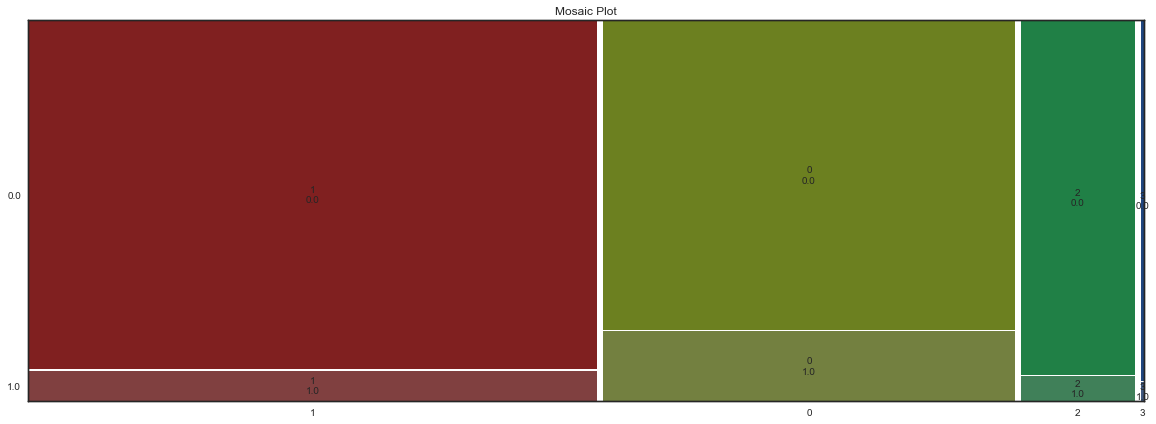

In [83]:
# モザイク図
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
mosaic(data=dataset, ax=ax, index=['solvency_score', 'y'], title='Mosaic Plot')
plt.xticks(rotation=90)
plt.show()

**all_campaign（全接触回数）**

In [ ]:
# "campaign","previous"の値を合計
dataset["all_campaign"] = dataset["campaign"] + dataset["previous"]

In [ ]:
# 対数化
dataset["all_campaign"] = dataset["all_campaign"].map(lambda i: np.log(i) if i > 0 else 0)

In [ ]:
# データセットの分布を確認
g = sns.distplot(dataset["all_campaign"], color="m", label="Skewness : %.2f"%(dataset["all_campaign"].skew()))
g = g.legend(loc="best")

In [ ]:
# 申込有無毎の分布
g = sns.kdeplot(dataset["all_campaign"][(train["y"] == 0) & (dataset["all_campaign"].notnull())], color="Red", shade = True)
g = sns.kdeplot(dataset["all_campaign"][(train["y"] == 1) & (dataset["all_campaign"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("all_campaign")
g.set_ylabel("Frequency")
g = g.legend(["Not applicarion","applicarion"])

### 3.3 特徴量選択

In [ ]:
# 不要カラムリスト
drop_list = ['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'date_of_week', 'solvency_score']

# 不要カラムの削除
dataset = dataset.drop(drop_list, axis=1)

In [ ]:
# 特徴量選択用の一時訓練データを生成

# 訓練データ
train_ds_tmp = dataset[dataset["flag"] == "train"].reset_index(drop=True)

# flagカラムを削除
train_ds_tmp = train_ds_tmp.drop("flag", axis=1)

# yカラムを整数型に変換
train_ds_tmp["y"] = train_ds_tmp["y"].astype(int)

# 訓練データを特徴量とラベルに分割
train_ds_X_tmp = train_ds_tmp.drop(labels = ["y"],axis = 1)
train_ds_y_tmp = train["y"]

#　訓練データを訓練セットとテストセットに分割
X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(train_ds_X_tmp, train_ds_y_tmp)

#### 3.3.1 XGBOOSTのfeature importances可視化

In [ ]:
# 変数の重要度の可視化
clf = xgb.XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.95)
clf.fit(X_train_tmp, y_train_tmp)

imp = clf.feature_importances_
names = X_train.columns

imp, names = zip(*sorted(zip(imp, names)))

plt.barh(range(len(names)), imp, align='center')
plt.yticks(range(len(names)), names)

plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.title('Importance of each feature')
plt.show()

#### 3.3.2 RFEによる特徴量選択

In [ ]:
# RFEによる特徴量選択
select = RFE(RandomForestClassifier(n_estimators=200), n_features_to_select=28)
select.fit(X_train_tmp, y_train_tmp)

# 選択された特徴量を可視化する
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [ ]:
# 具体的な列名で可視化
columns =pd.DataFrame(X_train_tmp.columns)
mask =pd.DataFrame(mask)
concat = pd.concat([columns, mask], axis=1)
concat

### 3.4 不要カラムの削除

In [105]:
# 不要カラムリスト
#drop_list = ['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'date_of_week', 'solvency_score','balance', 'duration', 'campaign', 'pdays', 'previous']
drop_list = ['default','housing','loan','job', 'marital', 'education', 'contact', 'month', 'poutcome', 'date_of_week', 'solvency_score','balance', 'duration', 'campaign', 'pdays', 'previous']


# 不要カラムの削除
dataset_dp = dataset.drop(drop_list, axis=1)

In [85]:
dataset_dp

,age,day,default,flag,housing,id,loan,y,balance_log,duration_log,campaign_log,pdays_log,previous_log,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,contact_cellular,contact_telephone,contact_unknown,date,date_of_week_0,date_of_week_1,date_of_week_2,date_of_week_3,date_of_week_4,date_of_week_5,date_of_week_6,solvency_score_0,solvency_score_1,solvency_score_2,solvency_score_3
0,39,3,0,train,1,1,0,1.0,9.372119,6.844815,0.000000,0.000000,0.000000,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,9547200,1,0,0,0,0,0,0,0,1,0,0
1,51,18,0,train,0,2,0,1.0,9.345133,5.147494,2.302585,0.000000,0.000000,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,9508320,0,0,0,0,1,0,0,1,0,0,0
2,36,13,0,train,0,3,0,1.0,9.253017,6.340359,0.000000,6.390241,0.693147,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,9555840,0,0,0,1,0,0,0,1,0,0,0
3,63,25,0,train,0,4,0,1.0,9.256651,6.047372,0.000000,0.000000,0.000000,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,9487584,0,1,0,0,0,0,0,1,0,0,0
4,31,30,0,train,0,5,0,1.0,9.245128,6.218600,0.000000,2.302585,0.693147,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,9570528,0,0,0,0,0,0,1,1,0,0,0
5,29,2,0,train,1,6,0,1.0,9.236008,6.561031,2.639057,0.000000,0.000000,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,9599040,0,0,0,0,1,0,0,0,1,0,0
6,37,6,0,train,1,7,0,1.0,9.215527,6.811244,0.000000,5.225747,2.197225,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,9681984,0,0,1,0,0,0,0,0,1,0,0
7,32,18,0,train,1,8,0,1.0,9.233080,6.091310,0.000000,5.587249,2.079442,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,9586080,0,0,0,1,0,0,0,0,1,0,0
8,31,7,0,train,1,9,0,1.0,9.210340,6.796824,0.693147,5.690359,0.693147,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,9576576,0,0,0,0,0,0,1,0,1,0,0
9,32,10,0,train,0,10,0,1.0,9.377125,5.459586,0.000000,4.634729,0.693147,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,9658656,0,0,0,1,0,0,0,1,0,0,0


### 3.5 データセットの整備

#### 3.5.1 データセットを訓練データと適用データに分割

In [106]:
# 訓練データと適用データに分割
train_ds = dataset_dp[dataset_dp["flag"] == "train"].reset_index(drop=True)
test_ds = dataset_dp[dataset_dp["flag"] == "test"].reset_index(drop=True)

# flagカラムを削除
train_ds = train_ds.drop("flag", axis=1)
test_ds = test_ds.drop("flag", axis=1)

# 適用データからyカラムを削除
test_ds = test_ds.drop("y", axis=1)

#### 3.5.2 訓練データを訓練セットとテストセットに分割

In [107]:
# yカラムを整数型に変換
train_ds["y"] = train_ds["y"].astype(int)

# 訓練データを特徴量とラベルに分割
train_ds_X = train_ds.drop(labels = ["y"],axis = 1)
train_ds_y = train["y"]

#　訓練データを訓練セットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(train_ds_X, train_ds_y)

#### 3.5.3 変数の重要度の可視化

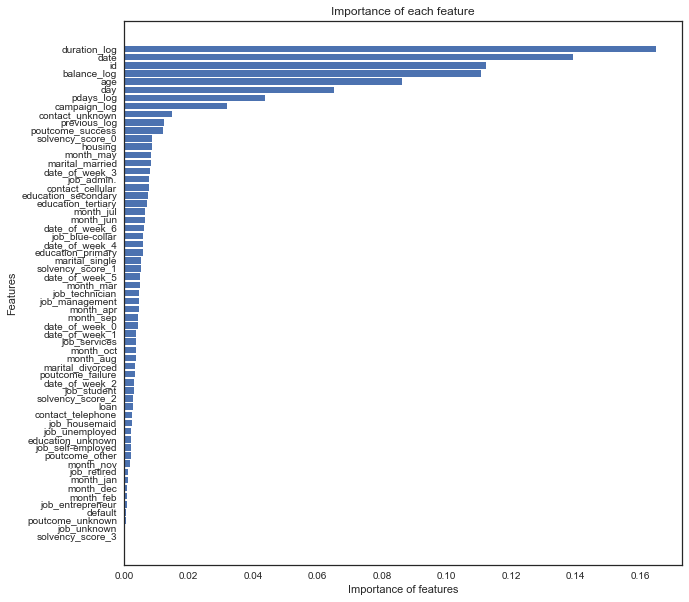

In [88]:
# 重要な特徴量を可視化
clf = xgb.XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.95)
clf_xgb = BalancedBaggingClassifier(base_estimator=clf, n_jobs=-1, n_estimators=10, ratio='auto')
clf_xgb.fit(X_train, y_train)

imp = np.mean([est.steps[1][1].feature_importances_ for est in clf_xgb.estimators_], axis=0)
names = X_train.columns

imp, names = zip(*sorted(zip(imp, names)))

plt.figure(figsize=(10,10))
plt.barh(range(len(names)), imp, align='center')
plt.yticks(range(len(names)), names)

plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.title('Importance of each feature')
plt.show()

## 4. モデリング

### 4.1 単一学習器でのモデリング

**XGBOOST**

ハイパーパラメータサーチは下部にて実施

In [108]:
# ベストパラメータを表示
print(best_parameters_xgb)

{'learning_rate': 0.01, 'n_estimators': 1000, 'reg_alpha': 0.12, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.3, 'subsample': 0.9, 'colsample_bytree': 0.6, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1}


In [109]:
# ベストパラメータでモデル再構築
xgb2 = xgb.XGBClassifier(**best_parameters_xgb)
ibl_xgb2 = BalancedBaggingClassifier(base_estimator=xgb2, n_jobs=-1, n_estimators=10, ratio='auto')
ibl_xgb2.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.3, learning_rate=0.01,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=1000, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.12, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
             random_state=None, ratio='auto', replacement=False, verbose=0,
             warm_start=False)

In [110]:
#　テストセットによる推定
y_pred_xgb = ibl_xgb2.predict(X_test)

# 混合行列
print(confusion_matrix(y_test, y_pred_xgb))

[[5017  958]
 [  89  718]]


In [111]:
#　適合率、再現率、f-値
print(classification_report(y_test, y_pred_xgb))

             precision    recall  f1-score   support

          0       0.98      0.84      0.91      5975
          1       0.43      0.89      0.58       807

avg / total       0.92      0.85      0.87      6782



In [112]:
#平均適合率
average_precision_score(y_test, ibl_xgb2.predict_proba(X_test)[:, 1])

0.62959298291448

In [113]:
# AUC
roc_auc_score(y_test, ibl_xgb2.predict_proba(X_test)[:, 1])

0.9327849932338896

In [114]:
# テストデータの予測
test_ds_y_bbcgs_xgb = pd.DataFrame(ibl_xgb2.predict_proba(test_ds))

# 通し番号と予測データの結合
result_bbcgs_xgb = pd.concat([IDtest, test_ds_y_bbcgs_xgb.iloc[:, -1]], axis=1)

# CSV出力
result_bbcgs_xgb.to_csv( './result/result_bbcgs_xgb_v20.csv', index=False, header=None)

### グリーディ法×BlancedBaggingClassifierによるxgboostハイパーパラメータのサーチ

1回目: max_depth, min_child_weight

In [1043]:
best_score_xgb = 0
scores_xgb = []

for max_depth in [x for x in range(3,10,2)]:
    for min_child_weight in [x for x in range(1,6,2)]:
        xgb_model = xgb.XGBClassifier(learning_rate = 0.1, 
                                n_estimators=100, 
                                max_depth=max_depth,
                                min_child_weight=min_child_weight,
                                gamma=0,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                objective= 'binary:logistic', 
                                nthread=4,
                                scale_pos_weight=1, 
                                seed=42)
        ibl_xgb = BalancedBaggingClassifier(base_estimator=xgb_model, n_jobs=-1, n_estimators=10, ratio='auto')
        ibl_xgb.fit(X_train, y_train)
        auc_roc = roc_auc_score(y_test, ibl_xgb.predict_proba(X_test)[:, 1])
        #scores
        pred_test = ibl_xgb.predict(X_test.values)
        pred_test_probs = ibl_xgb.predict_proba(X_test.values)
        fpr, tpr, thresholds = roc_curve(y_test.values.ravel(),pred_test)

        if  auc_roc > best_score_xgb:
            best_score_xgb = auc_roc
            best_parameters_xgb_1 = {'max_depth': max_depth, 'min_child_weight': min_child_weight}

In [1044]:
best_parameters_xgb_1

{'max_depth': 7, 'min_child_weight': 5}

2回目: max_depth

In [1059]:
best_score_xgb = 0
scores_xgb = []

for max_depth in [5,6,7,8,9]:
    xgb_model = xgb.XGBClassifier(learning_rate = 0.1, 
                            n_estimators=100, 
                            max_depth=max_depth,
                            min_child_weight=5,
                            gamma=0,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            objective= 'binary:logistic', 
                            nthread=4,
                            scale_pos_weight=1, 
                            seed=42)
    ibl_xgb = BalancedBaggingClassifier(base_estimator=xgb_model, n_jobs=-1, n_estimators=10, ratio='auto')
    ibl_xgb.fit(X_train, y_train)
    auc_roc = roc_auc_score(y_test, ibl_xgb.predict_proba(X_test)[:, 1])

    if  auc_roc > best_score_xgb:
        best_score_xgb = auc_roc
        best_parameters_xgb_2 = {'max_depth': max_depth}

In [1060]:
best_parameters_xgb_2

{'max_depth': 7}

3回目: gamma

In [1068]:
best_score_xgb = 0
scores_xgb = []

for gamma in [i/10.0 for i in range(0,5)]:
    xgb_model = xgb.XGBClassifier(learning_rate = 0.1, 
                            n_estimators=100, 
                            max_depth=7,
                            min_child_weight=5,
                            gamma=gamma,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            objective= 'binary:logistic', 
                            nthread=4,
                            scale_pos_weight=1, 
                            seed=42)
    ibl_xgb = BalancedBaggingClassifier(base_estimator=xgb_model, n_jobs=-1, n_estimators=10, ratio='auto')
    ibl_xgb.fit(X_train, y_train)
    auc_roc = roc_auc_score(y_test, ibl_xgb.predict_proba(X_test)[:, 1])
    
    if  auc_roc > best_score_xgb:
        best_score_xgb = auc_roc
        best_parameters_xgb_3 = {'gamma': gamma}

In [1069]:
best_parameters_xgb_3

{'gamma': 0.3}

4回目: gamma（※3回目の結果周辺をサーチ）

In [1070]:
best_score_xgb = 0
scores_xgb = []

for gamma in [0.28, 0.29, 0.3, 0.31, 0.32]:
    xgb_model = xgb.XGBClassifier(learning_rate = 0.1, 
                            n_estimators=100, 
                            max_depth=7,
                            min_child_weight=5,
                            gamma=gamma,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            objective= 'binary:logistic', 
                            nthread=4,
                            scale_pos_weight=1, 
                            seed=42)
    ibl_xgb = BalancedBaggingClassifier(base_estimator=xgb_model, n_jobs=-1, n_estimators=10, ratio='auto')
    ibl_xgb.fit(X_train, y_train)
    auc_roc = roc_auc_score(y_test, ibl_xgb.predict_proba(X_test)[:, 1])
    
    if  auc_roc > best_score_xgb:
        best_score_xgb = auc_roc
        best_parameters_xgb_4 = {'gamma': gamma}

In [1071]:
best_parameters_xgb_4

{'gamma': 0.3}

5回目: subsample, colsample_bytree

In [1072]:
best_score_xgb = 0
scores_xgb = []

for subsample in [i/10.0 for i in range(6,10)]:
    for colsample_bytree in [i/10.0 for i in range(6,10)]:
        xgb_model = xgb.XGBClassifier(learning_rate = 0.1, 
                                n_estimators=100, 
                                max_depth=7,
                                min_child_weight=5,
                                gamma=0.3,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree,
                                objective= 'binary:logistic', 
                                nthread=4,
                                scale_pos_weight=1, 
                                seed=42)
        ibl_xgb = BalancedBaggingClassifier(base_estimator=xgb_model, n_jobs=-1, n_estimators=10, ratio='auto')
        ibl_xgb.fit(X_train, y_train)
        auc_roc = roc_auc_score(y_test, ibl_xgb.predict_proba(X_test)[:, 1])

        if  auc_roc > best_score_xgb:
            best_score_xgb = auc_roc
            best_parameters_xgb_5 = {'subsample': subsample, 'colsample_bytree':colsample_bytree}

In [1073]:
best_parameters_xgb_5

{'colsample_bytree': 0.6, 'subsample': 0.9}

6回目: reg_alpha

In [1074]:
best_score_xgb = 0
scores_xgb = []

for reg_alpha in [0.001, 0.01, 0.1, 1, 10]:
    xgb_model = xgb.XGBClassifier(learning_rate = 0.1, 
                            n_estimators=100, 
                            reg_alpha=reg_alpha,
                            max_depth=7,
                            min_child_weight=5,
                            gamma=0.3,
                            subsample=0.9,
                            colsample_bytree=0.6,
                            objective= 'binary:logistic', 
                            nthread=4,
                            scale_pos_weight=1, 
                            seed=42)
    ibl_xgb = BalancedBaggingClassifier(base_estimator=xgb_model, n_jobs=-1, n_estimators=10, ratio='auto')
    ibl_xgb.fit(X_train, y_train)
    auc_roc = roc_auc_score(y_test, ibl_xgb.predict_proba(X_test)[:, 1])

    if  auc_roc > best_score_xgb:
        best_score_xgb = auc_roc
        best_parameters_xgb_6 = {'reg_alpha': reg_alpha}

In [1075]:
best_parameters_xgb_6

{'reg_alpha': 0.1}

7回目: reg_alpha（※6回目の結果周辺をサーチ）

In [1076]:
best_score_xgb = 0
scores_xgb = []

for reg_alpha in [0.02, 0.08, 0.1, 0.12, 0.18]:
    xgb_model = xgb.XGBClassifier(learning_rate = 0.1, 
                            n_estimators=100, 
                            reg_alpha=reg_alpha,
                            max_depth=7,
                            min_child_weight=5,
                            gamma=0.3,
                            subsample=0.9,
                            colsample_bytree=0.6,
                            objective= 'binary:logistic', 
                            nthread=4,
                            scale_pos_weight=1, 
                            seed=42)
    ibl_xgb = BalancedBaggingClassifier(base_estimator=xgb_model, n_jobs=-1, n_estimators=10, ratio='auto')
    ibl_xgb.fit(X_train, y_train)
    auc_roc = roc_auc_score(y_test, ibl_xgb.predict_proba(X_test)[:, 1])

    if  auc_roc > best_score_xgb:
        best_score_xgb = auc_roc
        best_parameters_xgb_7 = {'reg_alpha': reg_alpha}

In [1077]:
best_parameters_xgb_7

{'reg_alpha': 0.12}

ベストパラメータ

In [97]:
best_parameters_xgb = {'learning_rate' : 0.01, 
    'n_estimators':1000, 
    'reg_alpha':0.12,
    'max_depth':7,
    'min_child_weight':5,
    'gamma':0.3,
    'subsample':0.9,
    'colsample_bytree':0.6,
    'objective':'binary:logistic', 
    'nthread':4,
    'scale_pos_weight':1}

**ランダムフォレスト**

In [239]:
best_score_rf= 0
scores_rf = []

# reference: manual_grid_search_cv
for n_estimators in [100, 200]:
    rfc = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    ibl_rf = BalancedBaggingClassifier(base_estimator=rfc, n_jobs=-1, n_estimators=10, ratio='auto')
    ibl_rf.fit(X_train, y_train)
    auc_roc = roc_auc_score(y_test, ibl_rf.predict_proba(X_test)[:, 1])
    #scores
    pred_test = ibl_rf.predict(X_test.values)
    pred_test_probs = ibl_rf.predict_proba(X_test.values)
    fpr, tpr, thresholds = roc_curve(y_test.values.ravel(),pred_test)
    scores_rf.append((n_estimators,
                   auc_roc,
                   f1_score(y_test.values.ravel(),pred_test),
                   precision_score(y_test.values.ravel(),pred_test),
                   recall_score(y_test.values.ravel(),pred_test),
                   accuracy_score(y_test.values.ravel(),pred_test),
                   auc(fpr, tpr),
                   confusion_matrix(y_test.values.ravel(),pred_test)))
    if  auc_roc > best_score_rf:
        best_score_rf = auc_roc
        best_parameters_rf = {'n_estimators': n_estimators}

In [240]:
#scoresを表示
sampling_results_rf = pd.DataFrame(scores_rf,columns=['n_estimators','auc_roc', 'f1','precision','recall','accuracy','auc', 'confusion_matrix'])
sampling_results_rf

,n_estimators,auc_roc,f1,precision,recall,accuracy,auc,confusion_matrix
0,100,0.91942,0.545666,0.395401,0.88015,0.826895,0.849956,"[[4903, 1078], [96, 705]]"
1,200,0.91976,0.543772,0.393415,0.88015,0.825568,0.849204,"[[4894, 1087], [96, 705]]"


In [241]:
# ベストパラメータを表示
print(best_parameters_rf)

{'n_estimators': 200}


In [242]:
# ベストパラメータでモデル再構築
rfc2 = RandomForestClassifier(**best_parameters_rf)
ibl_rf2 = BalancedBaggingClassifier(base_estimator=rfc2, n_jobs=-1, n_estimators=10, ratio='auto')
ibl_rf2.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
             random_state=None, ratio='auto', replacement=False, verbose=0,
             warm_start=False)

In [243]:
#　テストセットによる推定
y_pred_rfc = ibl_rf2.predict(X_test)

# 混合行列
print(confusion_matrix(y_test, y_pred_rfc))

[[4887 1094]
 [  92  709]]


In [244]:
#　適合率、再現率、f-値
print(classification_report(y_test, y_pred_rfc))

             precision    recall  f1-score   support

          0       0.98      0.82      0.89      5981
          1       0.39      0.89      0.54       801

avg / total       0.91      0.83      0.85      6782



In [245]:
#平均適合率
average_precision_score(y_test, ibl_rf2.predict_proba(X_test)[:, 1])

0.5899474283863285

In [246]:
# AUC
roc_auc_score(y_test, ibl_rf2.predict_proba(X_test)[:, 1])

0.9194154356043409

In [ ]:
# テストデータの予測
test_ds_y_bbcgs_rf = pd.DataFrame(ibl_rf2.predict_proba(test_ds))

# 通し番号と予測データの結合
result_bbcgs_rf = pd.concat([IDtest, test_ds_y_bbcgs_rf.iloc[:, -1]], axis=1)

# CSV出力
result_bbcgs_rf.to_csv( './result/result_bbcgs_rf_v2.csv', index=False, header=None)